## Introduction

This notebook presents the exploratory data analysis (EDA) and visualization component of a project that aims to predict whether a customer will recommend a product based on their review. The dataset contains customer feedback from an e-commerce clothing retailer. The insights gained from this analysis will guide the development of a binary classification model to predict product recommendations.

## Load libraries and Inspect Data

We begin by loading the dataset and performing an initial inspection to understand the structure, column names, and types of data we are dealing with.

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv("../Data/Womens Clothing E-Commerce Reviews.csv") 




In [32]:
df.head()

,Index,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Index                    23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [34]:
df.describe()


,Index,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


In [35]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())
# Drop rows with missing values
df.dropna(inplace=True)
# Check for duplicates
print("Number of duplicate rows:", df.duplicated().sum())
# Drop duplicate rows
df.drop_duplicates(inplace=True)
# Check the distribution of ratings
print("Rating distribution:")
print(df['Rating'].value_counts())     

Missing values in each column:
Index                         0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64
Number of duplicate rows: 0
Rating distribution:
5    10858
4     4289
3     2464
2     1360
1      691
Name: Rating, dtype: int64


## Clean data

This step includes removing duplicates, standardizing column names for ease of use, and stripping whitespace from text entrieg.

In [36]:
df = df.drop(columns=['Index'])
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df.drop_duplicates(inplace=True)

## Handling Missing Values

We drop rows with missing values in essential columns such as 'review_text' and 'recommended_ind', which are critical for the prediction task. For less essential text fields like 'title', we impute missing values with empty strings to maintain consistency.

In [37]:
df = df.dropna(subset=['review_text', 'recommended_ind'])
df['title'] = df['title'].fillna('')

# Analyze Distributions

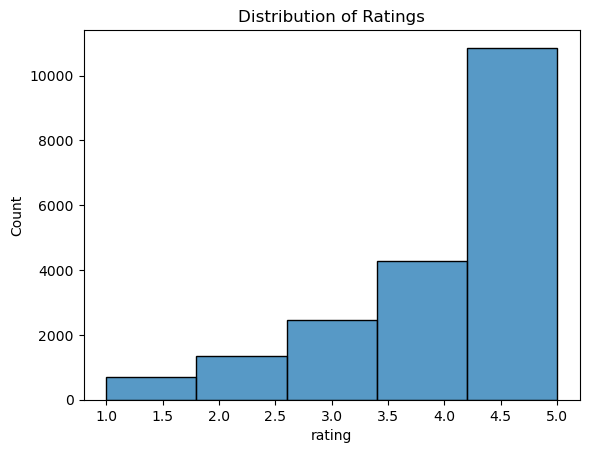

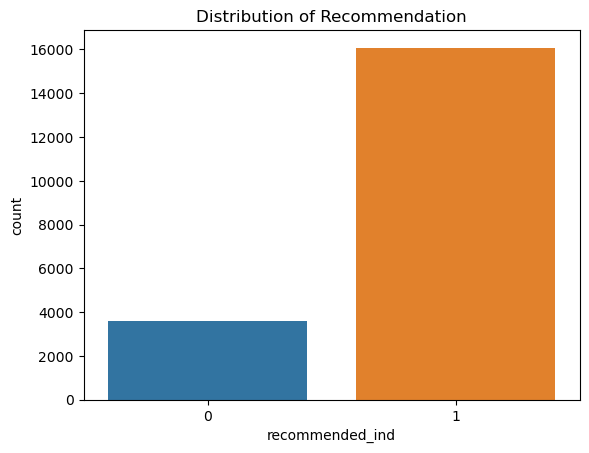

In [38]:
# Histogram for a numerical feature
sns.histplot(df['rating'], bins=5)
plt.title('Distribution of Ratings')
plt.show()

# Count plot for categorical feature
sns.countplot(x='recommended_ind', data=df)
plt.title('Distribution of Recommendation')
plt.show()


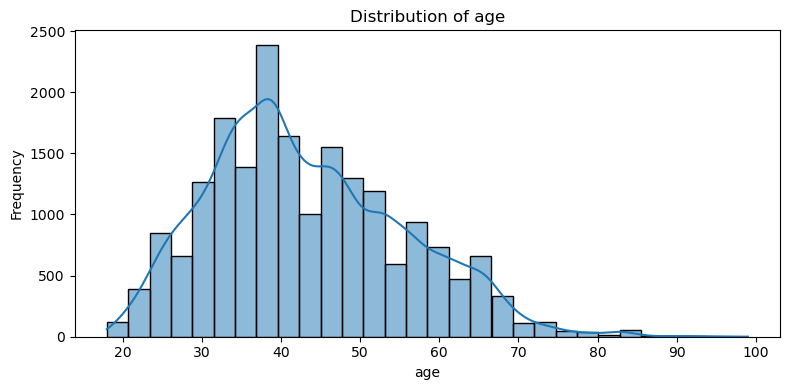

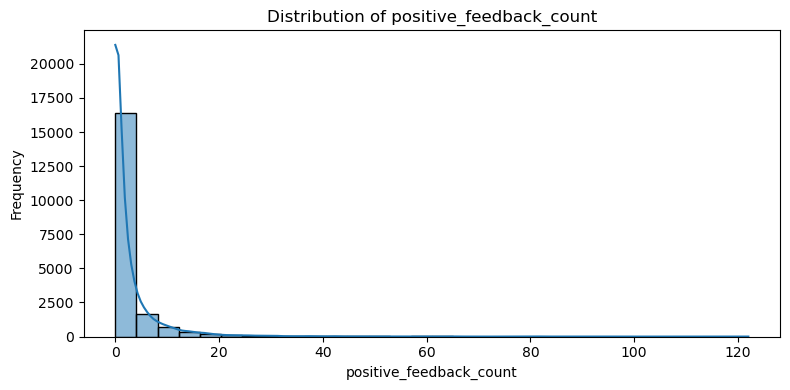

In [39]:
numeric_cols = ['age', 'positive_feedback_count']
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


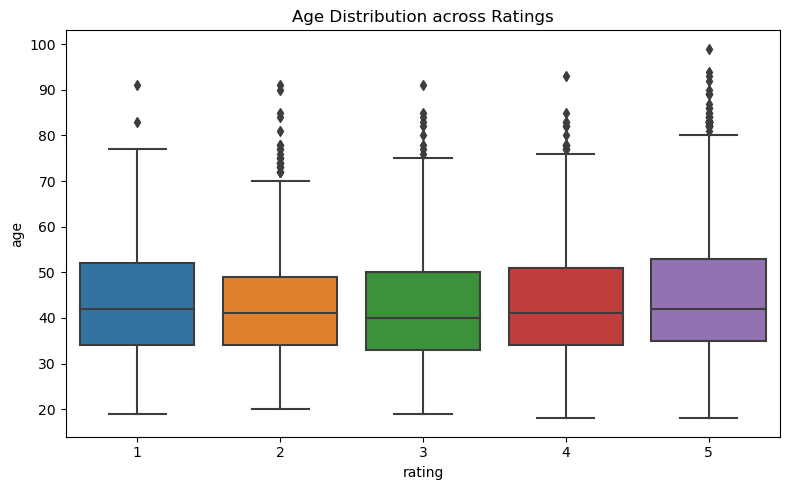

In [40]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='rating', y='age', data=df)
plt.title('Age Distribution across Ratings')
plt.tight_layout()
plt.show()


In [41]:
# percentage of customers above 80 years old
print("Percentage of customers above 80 years old:")
df[df['age'] > 80].shape[0]*100/df.shape[0]

Percentage of customers above 80 years old:


0.4170481131115858

In [42]:
# Filter out customers above 80 years old
df = df[df['age'] <= 80]

## Explore feature relationships

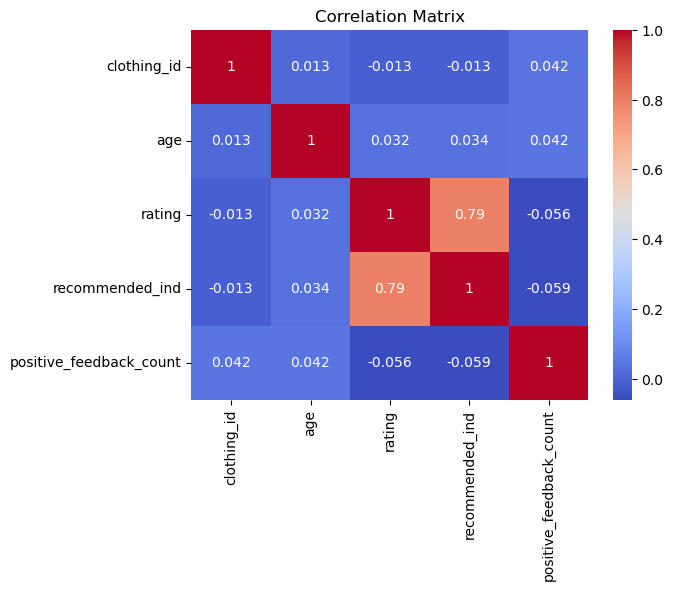

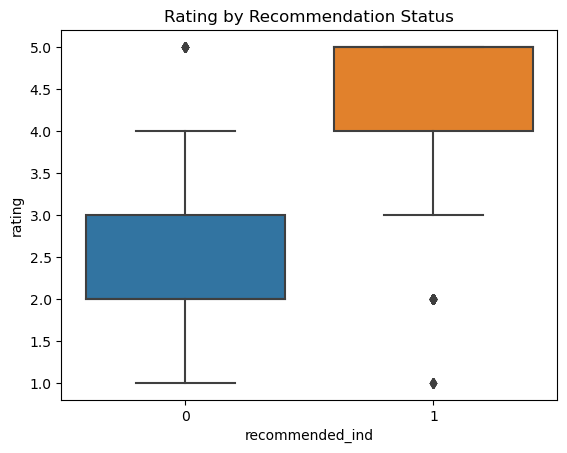

In [43]:
# Ensure only numeric columns are used for correlation
numeric_df = df.select_dtypes(include=['number']).dropna()

# Correlation heatmap
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Boxplot by target
sns.boxplot(x='recommended_ind', y='rating', data=df)
plt.title('Rating by Recommendation Status')
plt.show()


- Users who recommended tend to give significantly higher ratings compared to those who did not recommend.
- The rating distribution for the recommended group is more skewed toward the high end (4 and 5).

In [44]:
df = df[~(
    ((df['recommended_ind'] == 1) & (df['rating'].isin([1, 2]))) |
    ((df['recommended_ind'] == 0) & (df['rating'].isin([4, 5])))
)]


## Exploratory Data Analysis (EDA)

We conduct statistical analysis and visualizations to understand key characteristics of the data. This includes:

- Distribution of the target variable (`recommended_ind`)
- Relationship between age and recommendations
- Frequency of feedback across product categories
- Word clouds to visualize common themes in positive and negative reviews

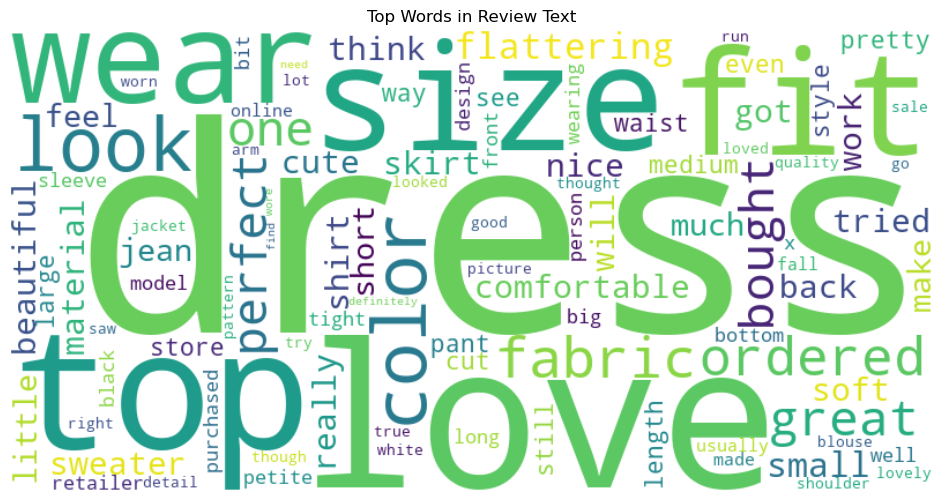

In [45]:
# remove missing values
text_data = df['review_text'].dropna()

combined_text = " ".join(text_data)

# Tạo Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(combined_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Words in Review Text")
plt.show()


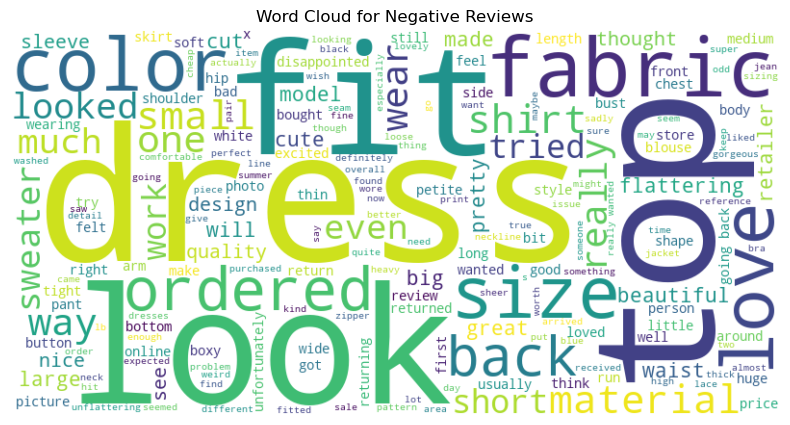

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter negative reviews
negative_reviews = df[df['recommended_ind'] == 0]['review_text'].dropna().str.cat(sep=' ')

# Generate word cloud
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Plot
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()


- Positive reviews: Customers love the dresses and tops for their attractive design, soft fabric, good fit, and comfort. Many are satisfied and reorder.
- Negative reviews: Some customers complain about small sizing, tight fit, or thin fabric, leading to returns.

In [47]:
for col in ['division_name', 'department_name', 'class_name']:
    rec_rate = df.groupby(col)['recommended_ind'].mean().sort_values(ascending=False)
    print(f'Recommendation rate by {col}:')
    print(rec_rate)
    print('-' * 40)

Recommendation rate by division_name:
division_name
Initmates         0.851082
General Petite    0.826831
General           0.819665
Name: recommended_ind, dtype: float64
----------------------------------------
Recommendation rate by department_name:
department_name
Bottoms     0.859280
Jackets     0.850174
Intimate    0.849819
Tops        0.812974
Dresses     0.811432
Trend       0.759615
Name: recommended_ind, dtype: float64
----------------------------------------
Recommendation rate by class_name:
class_name
Chemises          1.000000
Casual bottoms    1.000000
Layering          0.900901
Jeans             0.881002
Intimates         0.865546
Sleep             0.858824
Lounge            0.858657
Skirts            0.853690
Jackets           0.853288
Legwear           0.852713
Pants             0.850615
Outerwear         0.843284
Fine gauge        0.837897
Shorts            0.833333
Blouses           0.814291
Dresses           0.811432
Knits             0.810680
Swim              0.79

- Intimates division and Bottoms department have the highest recommendation rates, both above 84%.
- Some classes like Chemises and Casual bottoms show a perfect 100% recommendation rate, likely due to small sample sizes or exceptional feedback.
- Trend category consistently has the lowest recommendation rate (~75.7%), indicating potential areas for improvement.

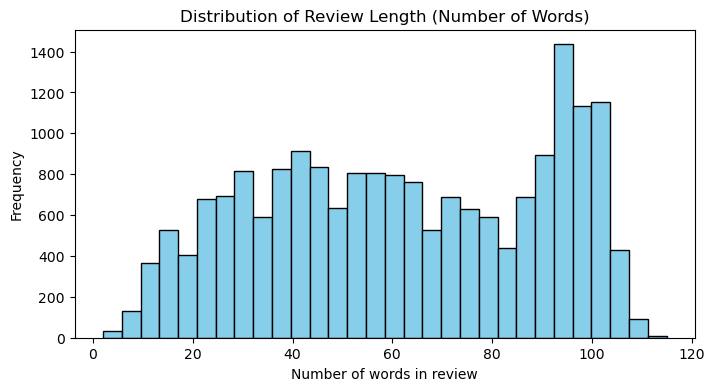

In [48]:
df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,4))
plt.hist(df['review_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Length (Number of Words)')
plt.xlabel('Number of words in review')
plt.ylabel('Frequency')
plt.show()


The highest frequency of reviews falls in the range of approximately 95 to 105 words, indicating that most reviewers tend to write relatively longer reviews in that range.

### One-Hot Encoding for Categorical Variables

To use categorical features in machine learning models, we convert them into binary format using one-hot encoding. This step ensures that our model can interpret and learn from features such as 'division_name', 'department_name', and 'class_name'.

In [49]:
df = pd.get_dummies(df, columns=['division_name', 'department_name', 'class_name'], drop_first=True)

### TF-IDF Vectorization

We apply TF-IDF to the review text to convert unstructured text data into numerical form. This method helps highlight the most relevant words in customer feedback for the classification task.

In [50]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf.fit_transform(df['review_text'])

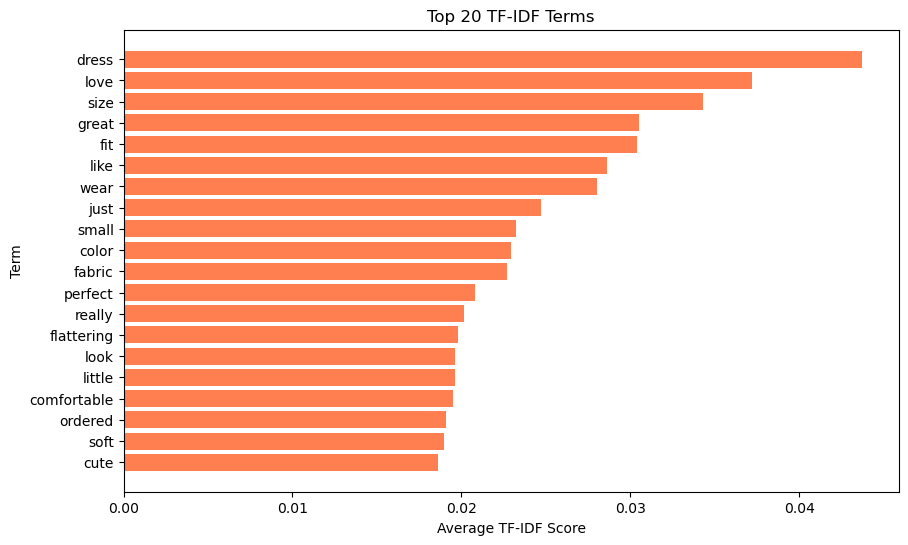

In [51]:
import numpy as np

tfidf_means = np.asarray(X_tfidf.mean(axis=0)).ravel()
terms = tfidf.get_feature_names_out()

# convert to DataFrame for easier handling
tfidf_df = pd.DataFrame({'term': terms, 'tfidf': tfidf_means})

# top 20 TF-IDF terms
top_tfidf = tfidf_df.sort_values(by='tfidf', ascending=False).head(20)

# plot
plt.figure(figsize=(10,6))
plt.barh(top_tfidf['term'][::-1], top_tfidf['tfidf'][::-1], color='coral')
plt.title('Top 20 TF-IDF Terms')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Term')
plt.show()

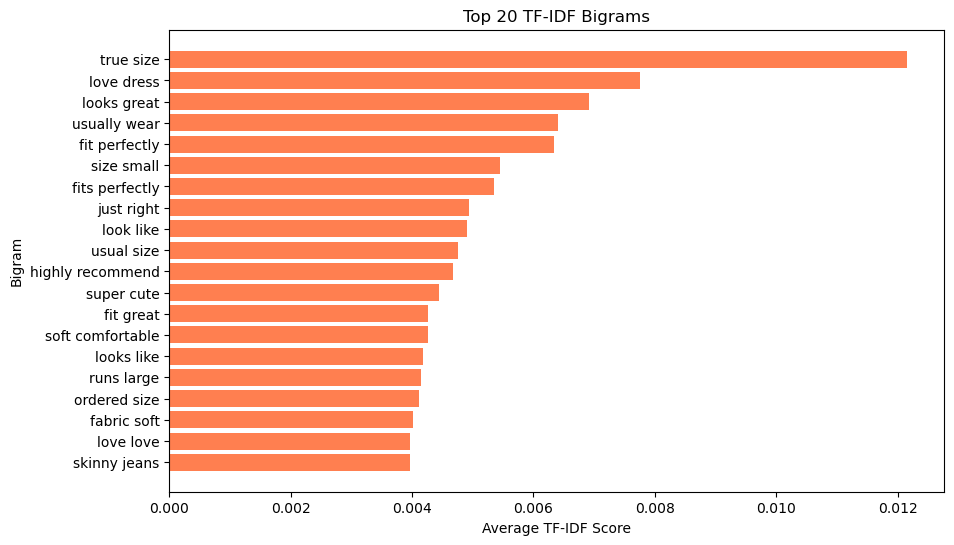

In [52]:
# bigrams
tfidf2 = TfidfVectorizer(ngram_range=(2, 2), max_features=5000, stop_words='english')
X_tfidf2 = tfidf2.fit_transform(df['review_text'].fillna(''))

tfidf2_means = np.asarray(X_tfidf2.mean(axis=0)).ravel()
terms2 = tfidf2.get_feature_names_out()

# Convert to DataFrame for easy handling
tfidf_df2 = pd.DataFrame({'term': terms2, 'tfidf': tfidf2_means})

# Select top 20 bigrams by average TF-IDF score
top_tfidf2 = tfidf_df2.sort_values(by='tfidf', ascending=False).head(20)

# Plot horizontal bar chart
plt.figure(figsize=(10,6))
plt.barh(top_tfidf2['term'][::-1], top_tfidf2['tfidf'][::-1], color='coral')
plt.title('Top 20 TF-IDF Bigrams')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Bigram')
plt.show()

- Customers focus heavily on size and fit, with phrases like "true size," "fit perfectly," and "runs large," highlighting the importance of choosing the right size.
- Feedback is predominantly positive regarding quality and style, with bigrams such as "love dress," "highly recommend," and "soft comfortable" reflecting satisfaction with the product’s look, comfort, and fabric.


In [53]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Create sentiment score column
df['sentiment_score'] = df['review_text'].fillna('').apply(lambda x: sia.polarity_scores(x)['compound'])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hoangnhu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


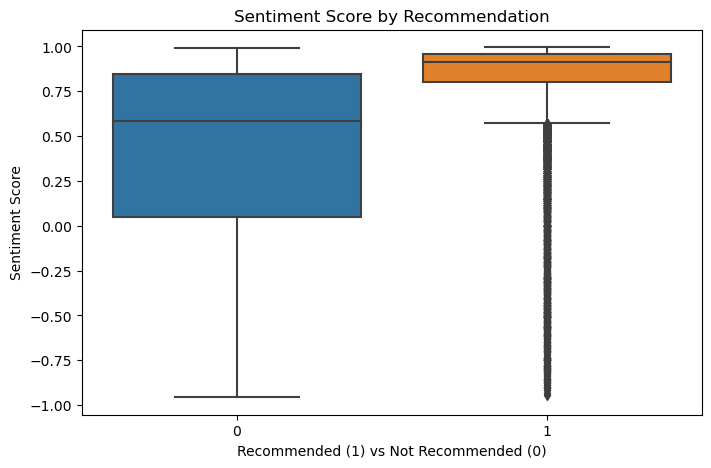

In [54]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(x='recommended_ind', y='sentiment_score', data=df)
plt.title('Sentiment Score by Recommendation')
plt.xlabel('Recommended (1) vs Not Recommended (0)')
plt.ylabel('Sentiment Score')
plt.show()


- The recommended group has a higher average and more concentrated sentiment score compared to the not recommended group. However, the recommended group still contains many low sentiment outliers, which may be due to some individual negative reviews. The not recommended group shows a wider dispersion of sentiment scores, possibly because of more diverse evaluations or a higher number of neutral/negative users.

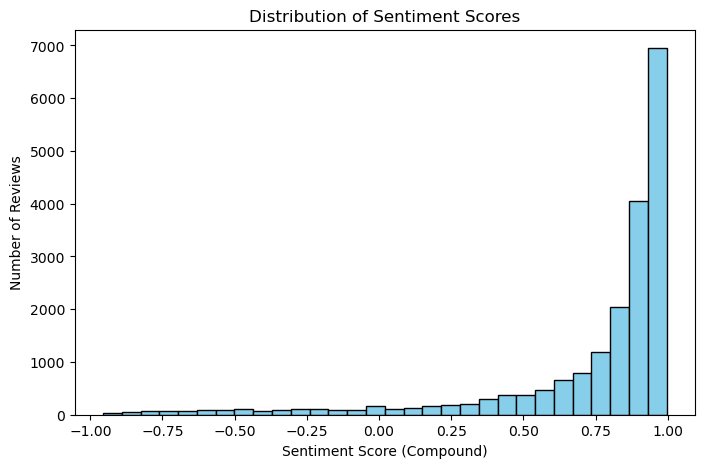

In [55]:
plt.figure(figsize=(8,5))
plt.hist(df['sentiment_score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score (Compound)')
plt.ylabel('Number of Reviews')
plt.show()


- Most sentiment scores are between 0.7 and 1, indicating that the majority of reviews have positive or very positive sentiment.
- A smaller portion of reviews have negative sentiment scores (below 0), but these are much fewer in number compared to positive ones.

In [56]:
# Save data for the next steps
df.to_csv('../Data/FE_reviews.csv', index=False)